/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


ValueError: ignored

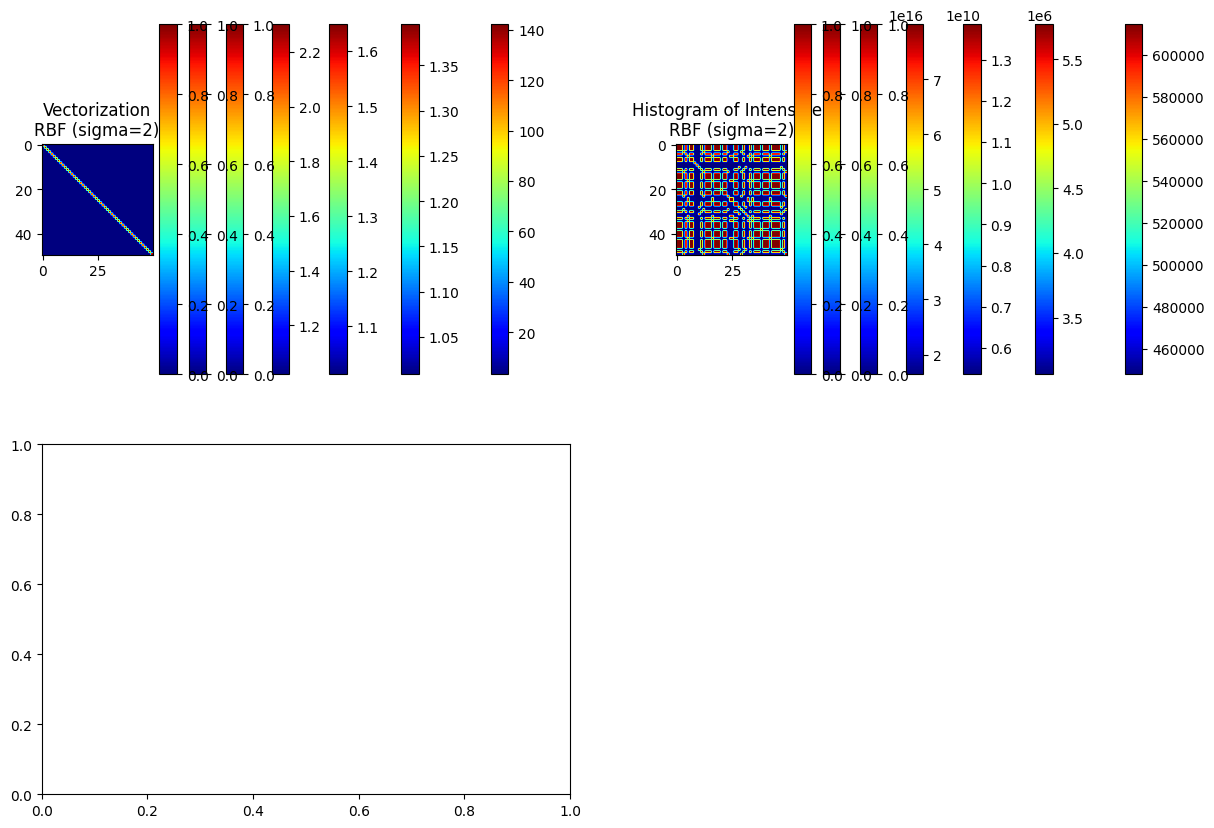

In [10]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Scale pixel values to 0-1

# Reset the index of y
y.reset_index(drop=True, inplace=True)

# Randomly select 50 samples
subset_size = 50
random_indices = np.random.choice(X.shape[0], subset_size, replace=False)
X_subset, y_subset = X.loc[random_indices].values, y.loc[random_indices].values

# Feature extraction functions
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_histogram_of_intensities(images):
    histograms = np.zeros((images.shape[0], 256))
    for i in range(images.shape[0]):
        histograms[i], _ = np.histogram(images[i], bins=256, range=(0, 256))
    return histograms


# Manual implementation of LBP (Local Binary Patterns)
def compute_lbp(image):
    radius = 3
    n_points = 8 * radius
    lbp_values = []
    for i in range(radius, image.shape[0] - radius):
        for j in range(radius, image.shape[1] - radius):
            center_pixel = image[i, j]
            lbp_code = 0
            for k in range(n_points):
                angle = 2 * np.pi * k / n_points
                x = int(np.round(i + radius * np.cos(angle)))
                y = int(np.round(j - radius * np.sin(angle)))
                lbp_code |= (image[x, y] > center_pixel) << k
            lbp_values.append(lbp_code)
    hist, _ = np.histogram(lbp_values, bins=np.arange(0, 2**n_points + 1), range=(0, 2**n_points))
    return hist

# Manual implementation of HOG (Histogram of Oriented Gradients)
def compute_hog(image):
    gradient_x = np.gradient(image, axis=0)
    gradient_y = np.gradient(image, axis=1)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x) * (180 / np.pi) % 180
    hog_features = []
    cells_per_block = 2
    pixels_per_cell = 8
    for i in range(0, image.shape[0], pixels_per_cell):
        for j in range(0, image.shape[1], pixels_per_cell):
            cell_magnitude = magnitude[i:i+pixels_per_cell, j:j+pixels_per_cell]
            cell_angle = angle[i:i+pixels_per_cell, j:j+pixels_per_cell]
            hist, _ = np.histogram(cell_angle, bins=9, range=(0, 180), weights=cell_magnitude)
            hog_features.extend(hist)
    return np.array(hog_features)

# Compute feature vectors
features = {
    'Vectorization': flatten_images(X_subset),
    'Histogram of Intensities': compute_histogram_of_intensities(X_subset),
    'Histogram of Local Binary Patterns': compute_lbp(X_subset),
    'Histogram of Oriented Gradients': compute_hog(X_subset)
}

# Compute Kernel Matrices
kernels = {
    'Linear': linear_kernel,
    'Polynomial (degree=2)': lambda X, Y: polynomial_kernel(X, Y, degree=2),
    'Polynomial (degree=3)': lambda X, Y: polynomial_kernel(X, Y, degree=3),
    'Polynomial (degree=5)': lambda X, Y: polynomial_kernel(X, Y, degree=5),
    'RBF (sigma=0.5)': lambda X, Y: rbf_kernel(X, Y, gamma=0.5),
    'RBF (sigma=1)': lambda X, Y: rbf_kernel(X, Y, gamma=1),
    'RBF (sigma=2)': lambda X, Y: rbf_kernel(X, Y, gamma=2)
}

# Compute and display Kernel Matrices
plt.figure(figsize=(15, 10))
for i, (feature_name, feature_matrix) in enumerate(features.items()):
    plt.subplot(2, 2, i + 1)
    for kernel_name, kernel_func in kernels.items():
        kernel_matrix = kernel_func(feature_matrix, feature_matrix)
        plt.imshow(kernel_matrix, cmap='jet')
        plt.title(f'{feature_name}\n{kernel_name}')
        plt.colorbar()
plt.tight_layout()
plt.show()

#SMO

In [ ]:
import numpy as np

class SVM:
    def __init__(self, C=1.0, tol=1e-3, max_iter=100):
        self.C = C  # Regularization parameter
        self.tol = tol  # Tolerance for stopping criterion
        self.max_iter = max_iter  # Maximum number of iterations
        self.alpha = None  # Lagrange multipliers
        self.b = 0  # Intercept
        self.errors = None  # Error cache
        self.X = None  # Training data
        self.y = None  # Target labels

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.alpha = np.zeros(X.shape[0])
        self.errors = self.decision_function(X) - y
        num_changed_alphas = 0
        examine_all = True

        iteration = 0
        while iteration < self.max_iter and (num_changed_alphas > 0 or examine_all):
            num_changed_alphas = 0
            if examine_all:
                for i in range(len(self.alpha)):
                    num_changed_alphas += self.examine_example(i)
            else:
                non_bound_indices = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
                for i in non_bound_indices:
                    num_changed_alphas += self.examine_example(i)
            if examine_all:
                examine_all = False
            elif num_changed_alphas == 0:
                examine_all = True
            iteration += 1

    def kernel(self, X1, X2):
        # Linear kernel function
        return np.dot(X1, X2.T)

    def decision_function(self, X):
        # Compute the decision function
        K = self.kernel(X, self.X)
        return np.dot(K, self.alpha * self.y) + self.b

    def predict(self, X):
        # Predict class labels
        return np.sign(self.decision_function(X) - self.b)

    def examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alpha[i2]
        E2 = self.errors[i2]

        r2 = E2 * y2

        if (r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0):
            if len(self.alpha[(self.alpha > 0) & (self.alpha < self.C)]) > 1:
                if self.errors[i2] > 0:
                    i1 = np.argmin(self.errors)
                elif self.errors[i2] <= 0:
                    i1 = np.argmax(self.errors)
                if self.take_step(i1, i2):
                    return 1

            for i1 in np.roll(np.where((self.alpha > 0) & (self.alpha < self.C))[0],
                              np.random.choice(np.where((self.alpha > 0) & (self.alpha < self.C))[0].size)):
                if self.take_step(i1, i2):
                    return 1

            for i1 in np.roll(np.arange(self.alpha.shape[0]), np.random.choice(self.alpha.shape[0], size=self.alpha.shape[0])):
                if self.take_step(i1, i2):
                    return 1
        return 0

    def take_step(self, i1, i2):
        if i1 == i2:
            return 0

        alpha1 = self.alpha[i1]
        alpha2 = self.alpha[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]

        s = y1 * y2

        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)

        if L == H:
            return 0

        k11 = self.kernel(self.X[i1], self.X[i1])
        k22 = self.kernel(self.X[i2], self.X[i2])
        k12 = self.kernel(self.X[i1], self.X[i2])
        eta = 2 * k12 - k11 - k22

        if eta < 0:
            a2_new = alpha2 - y2 * (E1 - E2) / eta
            a2_new = min(H, a2_new)
            a2_new = max(L, a2_new)
        else:
            Lobj = self.objective_function(L, i1, i2)
            Hobj = self.objective_function(H, i1, i2)
            if Lobj > Hobj + self.tol:
                a2_new = L
            elif Lobj < Hobj - self.tol:
                a2_new = H
            else:
                a2_new = alpha2

        if abs(a2_new - alpha2) < self.tol * (a2_new + alpha2 + self.tol):
            return 0

        a1_new = alpha1 + s * (alpha2 - a2_new)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = E1 + y1 * (a1_new - alpha1) * k11 + y2 * (a2_new - alpha2) * k12 + self.b
        b2 = E2 + y1 * (a1_new - alpha1) * k12 + y2 * (a2_new - alpha2) * k22 + self.b

        if 0 < a1_new < self.C:
            self.b = b1
        elif 0 < a2_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2

        # Update error cache
        delta_b = self.b - self.b_old
        self.errors += y1 * (a1_new - alpha1) * self.kernel(self.X, self.X[i1]).flatten() + \
                       y2 * (a2_new - alpha2) * self.kernel(self.X, self.X[i2]).flatten() - delta_b
        self.errors[i1] = 0
        self.errors[i2] = 0

        # Update Lagrange multipliers
        self.alpha[i1] = a1_new
        self.alpha[i2] = a2_new

        return 1

    def objective_function(self, alpha_new, i1, i2):
        return 0.5 * (self.kernel(self.X[i1], self.X[i1]) * (alpha_new ** 2)) + \
               0.5 * (self.kernel(self.X[i2], self.X[i2]) * (alpha_new ** 2)) + \
               self.y[i1] * self.y[i2] * self.kernel(self.X[i1], self.X[i2]) * alpha_new ** 2 - \
               alpha_new

# Extract 1000 samples out of 6000
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Scale pixel values to 0-1
subset_size = 1000
X_subset, y_subset = X[:subset_size].values, y[:subset_size].values

# Compute LBP and HOG features for the subset of data
lbp_features = np.array([compute_lbp(image.reshape(28, 28)) for image in X_subset])
hog_features = np.array([compute_hog(image.reshape(28, 28)) for image in X_subset])

# Concatenate features into a single matrix
features = np.concatenate((X_subset, lbp_features, hog_features), axis=1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features)

# Train and evaluate SVM with SMO algorithm
svm = SVM(C=1.0, tol=1e-3, max_iter=100)
svm.fit(X_train_scaled, y_subset)

# Prepare test data
X_test, y_test = X[subset_size:subset_size + 1000], y[subset_size:subset_size + 1000]

# Compute LBP and HOG features for the test data
lbp_features_test = np.array([compute_lbp(image.reshape(28, 28)) for image in X_test])
hog_features_test = np.array([compute_hog(image.reshape(28, 28)) for image in X_test])

# Concatenate features into a single matrix for test data
features_test = np.concatenate((X_test, lbp_features_test, hog_features_test), axis=1)

# Standardize the test features
X_test_scaled = scaler.transform(features_test)

# Predict using the trained SVM
predictions = svm.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test.astype(int), predictions.astype(int))
print(f'Accuracy with SMO SVM: {accuracy * 100:.2f}%')
